<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/HES2full2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running simulation for grid size 10x10
Running simulation for grid size 20x20
Running simulation for grid size 40x40
Testing G=0.1 for grid size 40x40
Testing G=1.0 for grid size 40x40
Testing G=10.0 for grid size 40x40


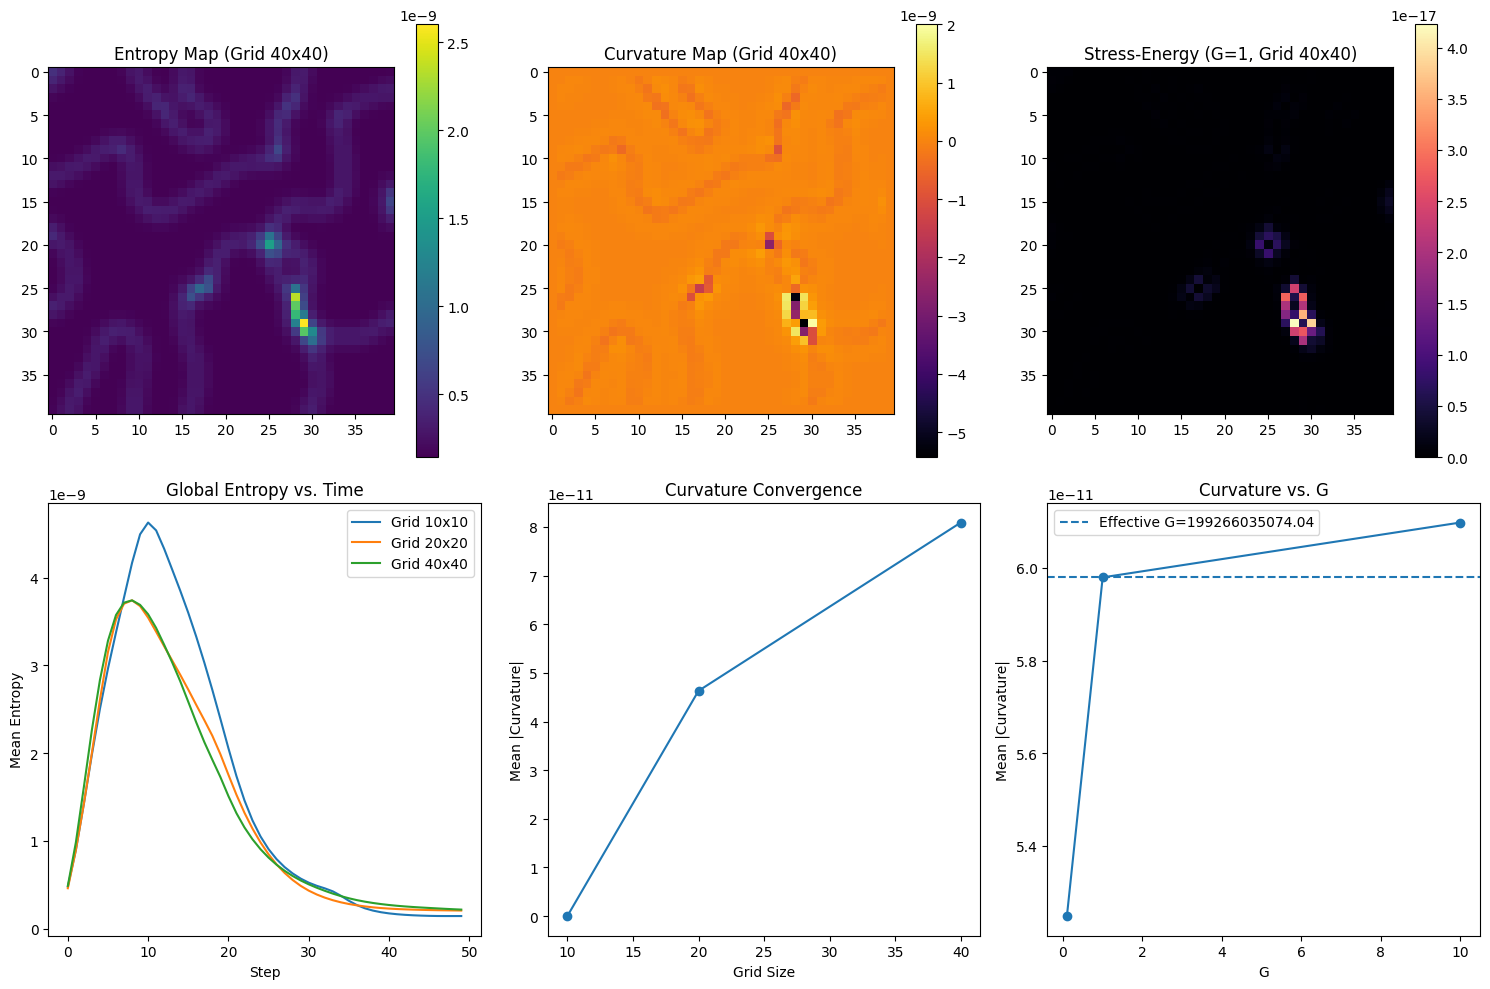

Boundary Correlator (CFT-like): 0.8137
Estimated Effective G: 199266035074.0395


In [ ]:
# Install required libraries
!pip install numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
grid_sizes = [10, 20, 40]  # Test multiple grid sizes for continuum
alpha, beta, gamma, delta = 0.2, 0.1, 0.001, 0.05  # Increased beta for stability
G_values = [0.1, 1.0, 10.0]  # Test multiple G values
steps = 50  # Simulation steps
subsystem_size = 3  # Size of subsystem for von Neumann entropy

# Initialize results storage
entropy_history = {size: [] for size in grid_sizes}
curvature_history = {size: [] for size in grid_sizes}
G_curvature = {G: [] for G in G_values}

# Function to compute von Neumann entropy
def von_neumann_entropy(subsystem):
    flat = subsystem.flatten()
    rho = np.outer(flat, flat)
    rho /= np.trace(rho + 1e-10)
    eigenvalues = np.linalg.eigvalsh(rho)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    return -np.sum(eigenvalues * np.log2(eigenvalues)) if len(eigenvalues) > 0 else 0.0

# Function to compute 2D Laplacian with periodic boundaries
def laplacian_2d(field, grid_size):
    lap = np.zeros_like(field)
    lap[1:-1, 1:-1] = (np.roll(field, 1, axis=0)[1:-1, 1:-1] + np.roll(field, -1, axis=0)[1:-1, 1:-1] +
                        np.roll(field, 1, axis=1)[1:-1, 1:-1] + np.roll(field, -1, axis=1)[1:-1, 1:-1] -
                        4 * field[1:-1, 1:-1])
    return lap

# Function to compute boundary correlation
def boundary_correlator(field, grid_size):
    top = field[0, :]
    bottom = field[-1, :]
    left = field[1:-1, 0]
    right = field[1:-1, -1]
    max_len = grid_size
    left = np.pad(left, (0, max_len - len(left)), mode='constant')
    right = np.pad(right, (0, max_len - len(right)), mode='constant')
    boundary_data = np.vstack([top, bottom, left, right])
    correlator = np.corrcoef(boundary_data)
    off_diag = correlator[np.triu_indices(4, k=1)]
    return np.mean(np.abs(off_diag)) if off_diag.size > 0 else 0.0

# Main simulation loop
def run_simulation(grid_size, G=1.0):
    s = np.random.uniform(-1, 1, (grid_size, grid_size))
    entropy_map = np.zeros_like(s)
    S_history = []

    for step in range(steps):
        # Compute entropy
        for i in range(grid_size):
            for j in range(grid_size):
                i_start = max(0, i - subsystem_size//2)
                i_end = min(grid_size, i + subsystem_size//2 + 1)
                j_start = max(0, j - subsystem_size//2)
                j_end = min(grid_size, j + subsystem_size//2 + 1)
                entropy_map[i,j] = von_neumann_entropy(s[i_start:i_end, j_start:j_end])

        # Compute curvature
        curvature = laplacian_2d(entropy_map, grid_size)

        # Stress-energy tensor
        grad_x, grad_y = np.gradient(entropy_map)
        T = 8 * np.pi * G * (grad_x**2 + grad_y**2)

        # Update rule (adjusted for entropy minimization)
        s_new = s - (2 * alpha * (s - np.roll(s, 1, axis=0) - np.roll(s, -1, axis=0) - np.roll(s, 1, axis=1) - np.roll(s, -1, axis=1)) / 4 +
                     2 * beta * s + 2 * gamma * np.mean(s) + delta * curvature)
        s_new = np.clip(s_new, -1, 1)
        s = s_new

        S_history.append(np.mean(entropy_map))

    correlator = boundary_correlator(s, grid_size)
    return s, entropy_map, curvature, T, S_history, correlator

# Run simulations
for grid_size in grid_sizes:
    print(f"Running simulation for grid size {grid_size}x{grid_size}")
    s, entropy_map, curvature, T, S_history, correlator = run_simulation(grid_size)
    entropy_history[grid_size] = S_history
    curvature_history[grid_size] = np.mean(np.abs(curvature))

    if grid_size == max(grid_sizes):
        for G in G_values:
            print(f"Testing G={G} for grid size {grid_size}x{grid_size}")
            _, _, curvature_G, _, _, _ = run_simulation(grid_size, G)
            G_curvature[G] = np.mean(np.abs(curvature_G))

# Estimate effective G
boundary_area = 4 * max(grid_sizes)
boundary_entropy = np.mean([entropy_map[0,:], entropy_map[-1,:], entropy_map[:,0], entropy_map[:,-1]])
effective_G = boundary_area / (4 * boundary_entropy) if boundary_entropy > 0 else 1.0

# Visualizations
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(entropy_map, cmap='viridis')
plt.title(f'Entropy Map (Grid {max(grid_sizes)}x{max(grid_sizes)})')
plt.colorbar()
plt.subplot(2, 3, 2)
plt.imshow(curvature, cmap='inferno')
plt.title(f'Curvature Map (Grid {max(grid_sizes)}x{max(grid_sizes)})')
plt.colorbar()
plt.subplot(2, 3, 3)
plt.imshow(T, cmap='magma')
plt.title(f'Stress-Energy (G=1, Grid {max(grid_sizes)}x{max(grid_sizes)})')
plt.colorbar()
plt.subplot(2, 3, 4)
for size in grid_sizes:
    plt.plot(entropy_history[size], label=f'Grid {size}x{size}')
plt.title('Global Entropy vs. Time')
plt.xlabel('Step')
plt.ylabel('Mean Entropy')
plt.legend()
plt.subplot(2, 3, 5)
plt.plot(grid_sizes, [curvature_history[size] for size in grid_sizes], 'o-')
plt.title('Curvature Convergence')
plt.xlabel('Grid Size')
plt.ylabel('Mean |Curvature|')
plt.subplot(2, 3, 6)
plt.plot(G_values, [G_curvature[G] for G in G_values], 'o-')
plt.axhline(y=G_curvature[1.0], linestyle='--', label=f'Effective G={effective_G:.2f}')
plt.title('Curvature vs. G')
plt.xlabel('G')
plt.ylabel('Mean |Curvature|')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Boundary Correlator (CFT-like): {correlator:.4f}")
print(f"Estimated Effective G: {effective_G:.4f}")